# YOLOX detections + TRACKING submission made on COTS dataset (PART 2 - DETECTION)

This notebook based on the great work [YoloX inference on Kaggle for COTS [LB 0.507] !!!](https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507), please upvote it also! Weights from here [YoloX inference on Kaggle for COTS [LB 0.520+]](https://www.kaggle.com/dragonzhang/yolox-inference-on-kaggle-for-cots-lb-0-520). 

LB without tracking: 0.53   
LB with tracking: 0.539

If you like this work, please upvote :)

I've added online tracking algorithm based on previous frames detections using [norfair](https://github.com/tryolabs/norfair) library to increase recall and F2 score.   
You can find tracking code at inference loop cell. I've added comments with description how it works on inference loop, feel free to ask any questions at comments.   
It's just baseline, you can tune parameters and achieve better score. Good luck!  
 


This notebook shows how to detect starfish objects (COTS dataset) using YOLOX ON  Kaggle. First part - Building Cutom Model on Kaggle using YOLOX I implmeneted in notebook called [YoloX full training pipeline for COTS dataset](https://www.kaggle.com/remekkinas/yolox-full-training-pipeline-for-cots-dataset). It could be good starting point for build own custom model based on YOLOX detector. Full github repository you can find here - [YOLOX](https://github.com/Megvii-BaseDetection/YOLOX)

<div align = 'center'><img src='https://github.com/Megvii-BaseDetection/YOLOX/raw/main/assets/logo.png'/></div>

<div class="alert alert-success" role="alert">
This work consists of two parts:     
    <ul>
        <li> <a href="https://www.kaggle.com/remekkinas/yolox-full-training-pipeline-for-cots-dataset">YoloX full training pipeline for COTS dataset</a></li>
        <li> YOLOX detections submission made on COTS dataset</li>
    </ul>
    
</div>

<div class="alert alert-warning" role="alert"><strong><ul><li>This is DEOMO only! What does it mean? Inference is made so far on weak model - trained only on 20 epochs.</li><li>I really appreciate if you <u>vote on both of these notebooks</u> - thank you! I just share my work to make competition fun and more interesting.</li></ul> </strong></div>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import importlib
import cv2 
import pandas as pd

from PIL import Image
from IPython.display import display

### INSTALL YOLOX 
<div class="alert alert-warning" role="alert"><strong>It unfortunately requires a lot of Kaggle enviroment hacking :) due to competition limitation - no internet access during submission.</strong></div>

In [2]:
# download required packages - first time when I created database (https://www.kaggle.com/remekkinas/yolox-cots-models) with required moduls for YOLOX
# don't use this section of code until Kaggle doesn't change something in the environment (!!)


#%mkdir /kaggle/working/yolox-dep
#!pip download pip -d "/kaggle/working/yolox-dep"
#!pip download loguru -d "/kaggle/working/yolox-dep"
#!pip download ninja -d "/kaggle/working/yolox-dep"
#!pip download onnx=="1.8.1" -d "/kaggle/working/yolox-dep"
#!pip download onnxruntime=="1.8.0" -d "/kaggle/working/yolox-dep"
#!pip download onnxoptimizer>="0.2.5" -d "/kaggle/working/yolox-dep"
#!pip download thop -d "/kaggle/working/yolox-dep"
#!pip download tabulate -d "/kaggle/working/yolox-dep"
#!pip download onnx-simplifier==0.3.5 -d "/kaggle/working/yolox-dep"

In [3]:
# Copy YOLOX and required modules from local repository (Kaggle dataset -> https://www.kaggle.com/remekkinas/yolox-cots-models)
%cp -r /kaggle/input/yolox-cots-models /kaggle/working/
%cd /kaggle/working/yolox-cots-models/yolox-dep

/kaggle/working/yolox-cots-models/yolox-dep


In [4]:
# Install YOLOX required modules

!pip install pip-21.3.1-py3-none-any.whl -f ./ --no-index
!pip install loguru-0.5.3-py3-none-any.whl -f ./ --no-index
!pip install ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl -f ./ --no-index
!pip install onnx-1.8.1-cp37-cp37m-manylinux2010_x86_64.whl -f ./ --no-index
!pip install onnxruntime-1.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl -f ./ --no-index
!pip install onnxoptimizer-0.2.6-cp37-cp37m-manylinux2014_x86_64.whl -f ./ --no-index
!pip install thop-0.0.31.post2005241907-py3-none-any.whl -f ./ --no-index
!pip install tabulate-0.8.9-py3-none-any.whl -f ./ --no-index
#!pip install onnx-simplifier-0.3.6.tar.gz -f ./ --no-index

Looking in links: ./
Processing ./pip-21.3.1-py3-none-any.whl
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Looking in links: ./
Processing ./loguru-0.5.3-py3-none-any.whl
Looking in links: ./
Processing ./ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl
Looking in links: ./
Processing ./onnx-1.8.1-cp37-cp37m-manylinux2010_x86_64.whl
Looking in links: ./
Processing ./onnxruntime-1.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Looking in links: ./
Processing ./onnxoptimizer-0.2.6-cp37-cp37m-manylinux2014_x86_64.whl
Looking in links: ./
Processing ./thop-0.0.31.post2005241907-py3-none-any.whl
Looking in links: ./
Processing ./tabulate-0.8.9-py3-none-any.whl
tabulate is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [5]:
# Install YOLOX
%cd /kaggle/working/yolox-cots-models/YOLOX
!pip install -r requirements.txt
!pip install -v -e . 

/kaggle/working/yolox-cots-models/YOLOX
Using pip 21.3.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Obtaining file:///kaggle/working/yolox-cots-models/YOLOX
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info
  writing /tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/dependency_links.txt
  writing top-level names to /tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/SOURCES.txt'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-fmt4d7x4/yolox.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Running setup.py develop for yolox
    Running command /opt/conda/bin/python3.7 -c 'import io, os, sys, setuptools, tokenize; sy

In [6]:
# Install CocoAPI tool
%cd /kaggle/working/yolox-cots-models/yolox-dep/cocoapi/PythonAPI

!make
!make install
!python setup.py install

/kaggle/working/yolox-cots-models/yolox-dep/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/yolox-cots-models/yolox-dep/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I../common -I/opt/conda/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -

In [7]:
import pycocotools

In [8]:
# norfair dependencies
%cd /kaggle/input/norfair031py3/
!pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
!pip install rich-9.13.0-py3-none-any.whl

!mkdir /kaggle/working/tmp
!cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
%cd /kaggle/working/tmp/filterpy-1.4.5/
!pip install .
!rm -rf /kaggle/working/tmp

# norfair
%cd /kaggle/input/norfair031py3/
!pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index

/kaggle/input/norfair031py3
Looking in links: ./
Processing ./commonmark-0.9.1-py2.py3-none-any.whl
Processing ./rich-9.13.0-py3-none-any.whl
/kaggle/working/tmp/filterpy-1.4.5
Processing /kaggle/working/tmp/filterpy-1.4.5
  Preparing metadata (setup.py) ... - done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=81a04656aa86265eb89e5a3b20d95a1aa910098867d94e21f958d661c8f74bbf
  Stored in directory: /root/.cache/pip/wheels/0e/ba/6d/20557ee403bc0c849d9fe3b358ded9918d7d2b0c5b0253fc99
Successfully built filterpy
/kaggle/input/norfair031py3
Looking in links: ./
Processing ./norfair-0.3.1-py3-none-any.whl


### TEST MODEL - MAKE INFERENCE ON SAMPLE DATA


In [9]:
%cd /kaggle/working/yolox-cots-models/YOLOX

CHECKPOINT_FILE = '/kaggle/input/f0-25-yolox-pth/YOLOX_outputs/cots_config/best_ckpt.pth'

/kaggle/working/yolox-cots-models/YOLOX


In [10]:
config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 1
        self.width = 1
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.num_classes = 1

'''

with open('cots_config.py', 'w') as f:
    f.write(config_file_template)

In [11]:
from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "starfish",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# set inference parameters
test_size = (800, 1280)
num_classes = 1
confthre = 0.35
nmsthre = 0.4


# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = CHECKPOINT_FILE
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [12]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )

    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores

In [13]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            x0 = int(box[0])
            y0 = int(box[1])
            x1 = int(box[2])
            y1 = int(box[3])

            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

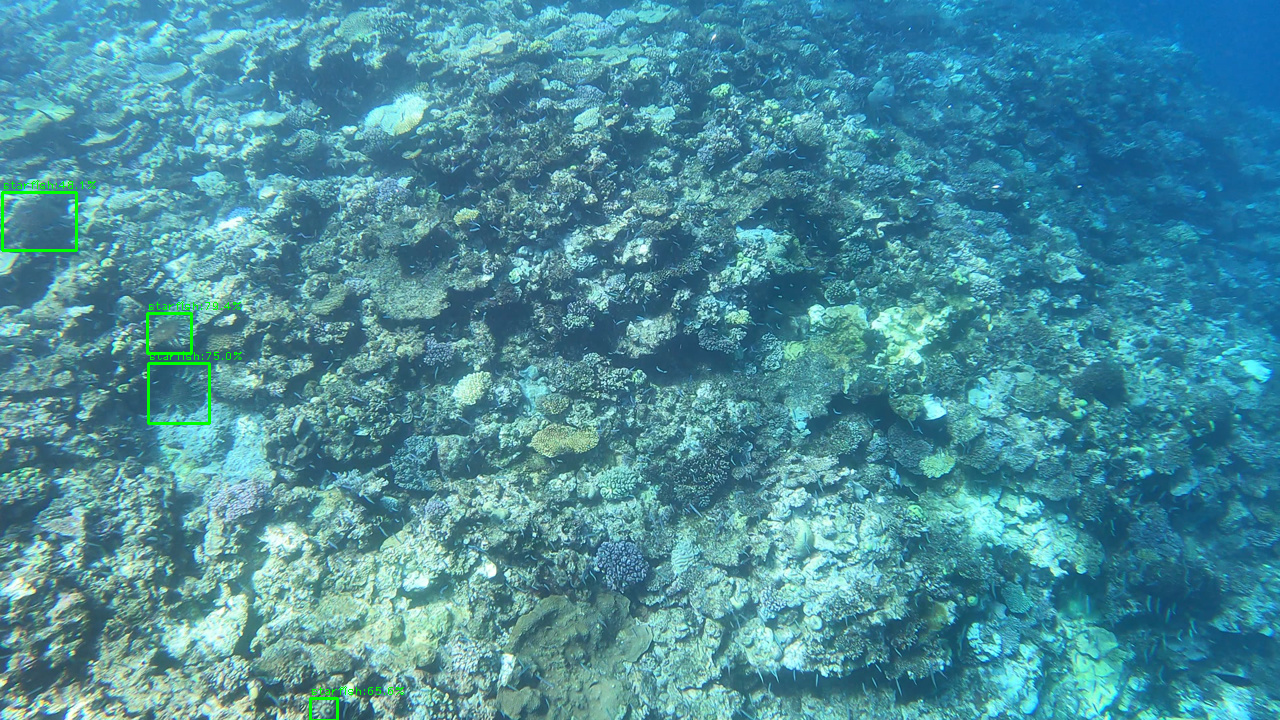

In [14]:
TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0/9674.jpg"
img = cv2.imread(TEST_IMAGE_PATH)

# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Draw predictions
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

## SUBMIT PREDICTION TO COMPETITION

In [15]:
%cd /kaggle/working/

/kaggle/working


In [16]:
import greatbarrierreef

env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [17]:
##############################################################
#                      Tracking helpers                      #
##############################################################

import numpy as np
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)
        

In [18]:
submission_dict = {
    'id': [],
    'prediction_string': [],
}


#######################################################
#                      Tracking                       #
#######################################################

# Tracker will update tracks based on detections from current frame
# Matching based on euclidean distance between bbox centers of detections 
# from current frame and tracked_objects based on previous frames
# You can check it's parameters in norfair docs
# https://github.com/tryolabs/norfair/blob/master/docs/README.md
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

# Save frame_id into detection to know which tracks have no detections on current frame
frame_id = 0
#######################################################


for (image_np, sample_prediction_df) in iter_test:
 
    bboxes, bbclasses, scores = yolox_inference(image_np[:,:,::-1], model, test_size)
    
    predictions = []
    detects = []
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        x_min = int(box[0])
        y_min = int(box[1])
        x_max = int(box[2])
        y_max = int(box[3])
        detects.append([x_min, y_min, x_max, y_max, score])
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    
    #######################################################
    #                      Tracking                       #
    #######################################################
    
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        if last_detected_frame_id + 1 != frame_id:  # Track only one frame forward
            continue

        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    #######################################################
    
    prediction_str = ' '.join(predictions)
    sample_prediction_df['annotations'] = prediction_str
    env.predict(sample_prediction_df)

    print('Prediction:', prediction_str)
    frame_id += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Prediction: 
Prediction: 
Prediction: 


In [19]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

,index,annotations
0,0,NaN
1,1,NaN
2,2,NaN


<div class="alert alert-success" role="alert">
    Find this notebook helpful? :) Please give me a vote ;) Thank you
 </div>